In [ ]:
import zipfile
import pandas as pd
import torch
from transformers import AutoTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import joblib
import warnings
import gensim
import nltk
from nltk.tag import map_tag
!pip install ax-platform
from ax import optimize

warnings.filterwarnings("ignore")

# Download necessary NLTK resources
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

# Step 1: Prepare Dataset
zip_file_path = '/content/WiC_dataset.zip'
extract_dir = '/content/WiC_dataset'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

dataset_path = r'/content/WiC_dataset/train/train.data.txt'
data = pd.read_csv(dataset_path, delimiter='\t', header=None)

gold_labels_path = '/content/WiC_dataset/train/train.gold.txt'
with open(gold_labels_path, 'r') as file:
    gold_labels = [line.strip() for line in file]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [ ]:
# Step 2: Load BERT Tokenizer and Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)
model.eval()

def emb(text):
    tokens = text.lower().split(' ')
    tokenized_words = ['[CLS]'] + [token for word in tokens for token in tokenizer.tokenize(word)] + ['[SEP]']
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_words)
    segments_ids = [1] * len(tokenized_words)

    tokens_tensor = torch.tensor([indexed_tokens]).to(device)
    segments_tensors = torch.tensor([segments_ids]).to(device)

    with torch.no_grad():
        encoded_layers = model(tokens_tensor, segments_tensors)[0]
    return encoded_layers[0].mean(dim=0).cpu().numpy()

In [ ]:
# Step 3: Generate Embeddings
data['emb1'] = data[3].apply(lambda x: emb(x))
data['emb2'] = data[4].apply(lambda x: emb(x))

In [ ]:
# Step 4: Generate Frequency Dictionary
nltk.download('averaged_perceptron_tagger_eng')
print("Generating word frequency dictionary...")
record = dict()
for sentence in data[3].tolist() + data[4].tolist():
    tokens = gensim.utils.simple_preprocess(sentence, min_len=2)
    pos = nltk.pos_tag(tokens, lang='eng')
    for word_index in range(len(tokens)):
        word_pos = map_tag('en-ptb', 'universal', pos[word_index][1])
        word_stop = 'STOP' if tokens[word_index] in gensim.parsing.preprocessing.STOPWORDS else 'NON_STOP'
        record[(tokens[word_index], word_pos, word_stop)] = record.get((tokens[word_index], word_pos, word_stop), [0])
        record[(tokens[word_index], word_pos, word_stop)][0] += 1

print("Saving frequency dictionary...")
joblib.dump(record, 'freqDictAutoSaveV4')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Generating word frequency dictionary...
Saving frequency dictionary...


['freqDictAutoSaveV4']

In [ ]:
# Step 5: Compute Log Frequencies and Stop Word Status
stop_words = {key[0] for key in record.keys() if key[2] == 'STOP'}
data['log2freq1'] = data[3].apply(lambda x: np.mean([np.log2(record.get((token, 'NOUN', 'NON_STOP'), [1])[0]) for token in gensim.utils.simple_preprocess(x, min_len=2)]))
data['log2freq2'] = data[4].apply(lambda x: np.mean([np.log2(record.get((token, 'NOUN', 'NON_STOP'), [1])[0]) for token in gensim.utils.simple_preprocess(x, min_len=2)]))
data['is_stop_word1'] = data[3].apply(lambda x: any(token in stop_words for token in gensim.utils.simple_preprocess(x, min_len=2)))
data['is_stop_word2'] = data[4].apply(lambda x: any(token in stop_words for token in gensim.utils.simple_preprocess(x, min_len=2)))

In [ ]:
# Step 6: Define Discounting Functions
def alpha(log_freq, is_stop_word, params):
    """
    Calculate alpha for discounted norm based on word frequency and stop word status.
    Args:
        log_freq (float): Logarithm of word frequency.
        is_stop_word (bool): Whether the word is a stop word.
        params (dict): Dictionary containing 'ms', 'bs', 'mn', 'bn'.
    Returns:
        float: Discount factor alpha.
    """
    if is_stop_word:
        return 1 + params['ms'] * (params['bs'] - log_freq)
    else:
        return 1 + params['mn'] * (params['bn'] - log_freq)

def discounted_cosine_similarity(embedding1, embedding2, log_freq1, log_freq2, is_stop_word1, is_stop_word2, params):
    """
    Calculate discounted cosine similarity between two embeddings.
    Args:
        embedding1, embedding2 (np.array): Word embeddings.
        log_freq1, log_freq2 (float): Log frequencies of the words.
        is_stop_word1, is_stop_word2 (bool): Stop word statuses.
        params (dict): Parameters for discounting.
    Returns:
        float: Discounted cosine similarity score.
    """
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    alpha1 = alpha(log_freq1, is_stop_word1, params)
    alpha2 = alpha(log_freq2, is_stop_word2, params)
    discounted_norm1 = norm1 * alpha1
    discounted_norm2 = norm2 * alpha2
    return np.dot(embedding1, embedding2) / (discounted_norm1 * discounted_norm2)


In [ ]:
#step 7 define accuracy function
def acc_with_cosine(params, data, gold_labels):
    """
    Computes accuracy using the discounted cosine similarity.
    Args:
        params (dict): Contains 'ms', 'bs', 'mn', 'bn', 'threshold'.
        data (pd.DataFrame): Dataset to evaluate.
        gold_labels (list): Ground truth labels.
    Returns:
        float: Accuracy score.
    """
    score = 0
    threshold = params.get('threshold', 0.5)
    for index in range(len(data)):
        try:
            emb1 = np.array(data.iloc[index]['emb1'])
            emb2 = np.array(data.iloc[index]['emb2'])
            log_freq1 = data.iloc[index]['log2freq1']
            log_freq2 = data.iloc[index]['log2freq2']
            is_stop_word1 = data.iloc[index]['is_stop_word1']
            is_stop_word2 = data.iloc[index]['is_stop_word2']
            cos = discounted_cosine_similarity(emb1, emb2, log_freq1, log_freq2, is_stop_word1, is_stop_word2, params)
            temp = 'T' if cos >= threshold else 'F'
            if temp == gold_labels[index]:
                score += 1
        except Exception as e:
            print(f"Error at index {index}: {e}")
            continue
    return score / len(data)


In [ ]:
# Define parameter space for optimization
parameter_space = [
    {"name": "ms", "type": "range", "bounds": [0.0, 1.0]},
    {"name": "bs", "type": "range", "bounds": [0.0, 1.0]},
    {"name": "mn", "type": "range", "bounds": [0.0, 1.0]},
    {"name": "bn", "type": "range", "bounds": [0.0, 5.0]},
    {"name": "threshold", "type": "range", "bounds": [0.4, 0.8]},
]

# Update Objective Function
def objective_function(params):
    """
    Objective function for Bayesian optimization.
    Args:
        params (dict): Dictionary containing parameters for discounting and threshold.
    Returns:
        float: Accuracy score.
    """
    return acc_with_cosine(params, data, gold_labels)

from ax.service.managed_loop import optimize

# Run Bayesian Optimization
best_parameters, best_values, _, _ = optimize(
    parameters=parameter_space,
    evaluation_function=objective_function,
    minimize=False,
    total_trials=50,
)

print(f"Optimized Parameters: {best_parameters}")
print(f"Best Training Accuracy: {best_values}")



[INFO 11-17 15:33:27] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ms. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-17 15:33:27] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bs. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-17 15:33:27] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter mn. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-17 15:33:27] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bn. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11

Optimized Parameters: {'ms': 0.029133472569184044, 'bs': 0.756180340196175, 'mn': 0.0, 'bn': 0.0, 'threshold': 0.6519944181484889}
Best Training Accuracy: ({'objective': 0.6392526265309532}, {'objective': {'objective': 5.62934093264351e-06}})


In [ ]:
# Step 8: Save Results
data['cosine_similarity_discounted'] = data.apply(
    lambda row: discounted_cosine_similarity(
        row['emb1'], row['emb2'], row['log2freq1'], row['log2freq2'], row['is_stop_word1'], row['is_stop_word2'], best_parameters
    ),
    axis=1
)
data.to_csv('WIC_discounted_results.csv', index=False)

import json
with open('best_parameters.json', 'w') as f:
    json.dump(best_parameters, f)

All steps completed!


In [ ]:
# Step 9: Load WiC Dev Dataset
dev_dataset_path = '/content/WiC_dataset/dev/dev.data.txt'
dev_data = pd.read_csv(dev_dataset_path, delimiter='\t', header=None)

gold_labels_path = '/content/WiC_dataset/dev/dev.gold.txt'
with open(gold_labels_path, 'r') as file:
    dev_gold_labels = [line.strip() for line in file]

dev_data2 = pd.read_csv(dev_dataset_path, delimiter='\t', header=None)

gold_labels_path = '/content/WiC_dataset/dev/dev.gold.txt'
with open(gold_labels_path, 'r') as file:
    dev_gold_labels2 = [line.strip() for line in file]


def cosine_similarity_no_discount(embedding1, embedding2):
    """
    Compute non-discounted cosine similarity between two embeddings.
    """
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    return np.dot(embedding1, embedding2) / (norm1 * norm2)


dev_data['emb1'] = dev_data[3].apply(lambda x: emb(x))
dev_data['emb2'] = dev_data[4].apply(lambda x: emb(x))


threshold = 0.5  # same threshold as mentioned in the paper
correct_predictions = 0

for index in range(len(dev_data)):
    try:
        emb1 = np.array(dev_data.iloc[index]['emb1'])
        emb2 = np.array(dev_data.iloc[index]['emb2'])
        cosine_sim = cosine_similarity_no_discount(emb1, emb2)
        prediction = 'T' if cosine_sim >= threshold else 'F'
        if prediction == dev_gold_labels[index]:
            correct_predictions += 1
    except Exception as e:
        print(f"Error at index {index}: {e}")
        continue

baseline_accuracy = correct_predictions / len(dev_data)
print(f"Baseline Accuracy (Non-Discounted): {baseline_accuracy * 100:.2f}%")


Baseline Accuracy (Non-Discounted): 53.76%


In [ ]:

stop_words = {key[0] for key in record.keys() if key[2] == 'STOP'}

dev_data['log2freq1'] = dev_data[3].apply(lambda x: np.mean([
    np.log2(record.get((token, 'NOUN', 'NON_STOP'), [1])[0])
    for token in gensim.utils.simple_preprocess(x, min_len=2)
]))

dev_data['log2freq2'] = dev_data[4].apply(lambda x: np.mean([
    np.log2(record.get((token, 'NOUN', 'NON_STOP'), [1])[0])
    for token in gensim.utils.simple_preprocess(x, min_len=2)
]))

dev_data['is_stop_word1'] = dev_data[3].apply(lambda x: any(
    token in stop_words for token in gensim.utils.simple_preprocess(x, min_len=2)
))

dev_data['is_stop_word2'] = dev_data[4].apply(lambda x: any(
    token in stop_words for token in gensim.utils.simple_preprocess(x, min_len=2)
))


In [ ]:
dev_data['cosine_similarity_discounted'] = dev_data.apply(
    lambda row: discounted_cosine_similarity(
        row['emb1'], row['emb2'], row['log2freq1'], row['log2freq2'],
        row['is_stop_word1'], row['is_stop_word2'], best_parameters
    ),
    axis=1
)


In [ ]:
predictions = dev_data['cosine_similarity_discounted'].apply(
    lambda x: 'T' if x >= best_parameters['threshold'] else 'F'
)

# Compute discounted accuracy for the dev set
dev_accuracy = acc_with_cosine(best_parameters, dev_data, dev_gold_labels)
print(f"Discounted Accuracy on Dev Set: {dev_accuracy:.2%}")


Discounted Accuracy on Dev Set: 63.64%


In [ ]:
#step 10: perturbate data for robustness study
import random
import re
def perturbate_dev_data(dev_data):
    def add_typo(sentence):
        """Introduce typos by replacing or swapping characters in a word."""
        words = sentence.split()
        if not words:
            return sentence
        word_idx = random.randint(0, len(words) - 1)
        char_idx = random.randint(0, len(words[word_idx]) - 1)
        perturbed_word = (
            words[word_idx][:char_idx]
            + random.choice('abcdefghijklmnopqrstuvwxyz')
            + words[word_idx][char_idx + 1:]
        )
        words[word_idx] = perturbed_word
        return ' '.join(words)

    def replace_with_synonym(sentence, synonyms_dict):
        """Replace some words with synonyms from a given dictionary."""
        words = sentence.split()
        return ' '.join([synonyms_dict.get(word, word) for word in words])

    def introduce_grammar_error(sentence):
        """Introduce grammar errors by modifying verb forms or tenses."""
        return re.sub(r'\bis\b', 'are', sentence)

    def add_random_noise(sentence):
        """Insert random noise words into the sentence."""
        words = sentence.split()
        noise_words = ['xx', 'yy', 'zz', random.choice('abcdefghijklmnopqrstuvwxyz')]
        insert_pos = random.randint(0, len(words))
        words.insert(insert_pos, random.choice(noise_words))
        return ' '.join(words)

    synonyms_dict = {
        "board": "plank",
        "circulate": "distribute",
        "hook": "catch",
        "recreation": "leisure",
        "domesticity": "homeliness",
        "acquisition": "purchase",
        "meeting": "gathering",
        "nude": "bare",
        "mark": "impression",
        "association": "connection",
        "inclination": "tendency",
        "glaze": "coat",
        "piggyback": "carry",
        "pick": "choose",
        "lecture": "talk",
        "bondage": "captivity",
    }


    perturbed_dev = dev_data.copy()
    perturbed_dev[3] = perturbed_dev[3].apply(
        lambda x: add_typo(introduce_grammar_error(replace_with_synonym(x, synonyms_dict)))
    )
    perturbed_dev[4] = perturbed_dev[4].apply(
        lambda x: add_random_noise(introduce_grammar_error(add_typo(x)))
    )

    return perturbed_dev


In [ ]:
# Perturb the dev dataset
perturbed_dev_data = perturbate_dev_data(dev_data2)

# Display a sample of the perturbed dev data
print(perturbed_dev_data.info())
perturbed_dev_data.head(15)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       638 non-null    object
 1   1       638 non-null    object
 2   2       638 non-null    object
 3   3       638 non-null    object
 4   4       638 non-null    object
dtypes: object(5)
memory usage: 25.0+ KB
None


,0,1,2,3,4
0,board,N,2-2,Room and plank x,He nailed boaids across the windows . xx
1,circulate,V,0-4,Circulatf a rumor .,This letter are being zz circulated among thb ...
2,hook,V,0-1,Hoor a fish .,"He hooked a svake accidentally , and was so sc..."
3,recreation,N,1-9,For leisure he wrote poetry and solved crosxwo...,Drbg abuse are often regarded as a zz form of ...
4,domesticity,N,4-6,Making a hsbby of homeliness .,A xx royal family living in unpretentiuus dome...
5,acquisition,N,3-7,qhe child 's purchase of language .,xx That graahite tennis racquet are quite an a...
6,meeting,N,3-1,There wgs no gathering of minds .,The zz meeting elected w chairperson .
7,nude,N,4-4,They spam in the bare .,The marketing rule ' nude selms ' spread from ...
8,mark,N,4-8,He left an indelible impression on ihe America...,yy It was in London that he made his mirk .
9,association,N,7-2,Conditioning are a fowm of learning by connect...,Many close aksociations with England . yy


In [ ]:
perturbed_dev_data['log2freq1'] = perturbed_dev_data[3].apply(lambda x: np.mean([
    np.log2(record.get((token, 'NOUN', 'NON_STOP'), [1])[0])
    for token in gensim.utils.simple_preprocess(x, min_len=2)
]))

perturbed_dev_data['log2freq2'] = perturbed_dev_data[4].apply(lambda x: np.mean([
    np.log2(record.get((token, 'NOUN', 'NON_STOP'), [1])[0])
    for token in gensim.utils.simple_preprocess(x, min_len=2)
]))

perturbed_dev_data['is_stop_word1'] = perturbed_dev_data[3].apply(lambda x: any(
    token in stop_words for token in gensim.utils.simple_preprocess(x, min_len=2)
))

perturbed_dev_data['is_stop_word2'] = perturbed_dev_data[4].apply(lambda x: any(
    token in stop_words for token in gensim.utils.simple_preprocess(x, min_len=2)
))
perturbed_dev_data['emb1'] = perturbed_dev_data[3].apply(lambda x: emb(x))
perturbed_dev_data['emb2'] = perturbed_dev_data[4].apply(lambda x: emb(x))

In [ ]:
perturbed_dev_data['cosine_similarity_discounted'] = perturbed_dev_data.apply(
    lambda row: discounted_cosine_similarity(
        row['emb1'], row['emb2'], row['log2freq1'], row['log2freq2'],
        row['is_stop_word1'], row['is_stop_word2'], best_parameters
    ),
    axis=1
)


In [ ]:
perturbed_dev_data['predictions'] = perturbed_dev_data['cosine_similarity_discounted'].apply(
    lambda x: 'T' if x >= best_parameters['threshold'] else 'F'
)

from sklearn.metrics import accuracy_score
perturbed_accuracy = accuracy_score(dev_gold_labels, perturbed_dev_data['predictions'])
print(f"Discounted Accuracy on Perturbed Dev Set: {perturbed_accuracy:.2%}")


Discounted Accuracy on Perturbed Dev Set: 58.15%


In [ ]:
success_cases = perturbed_dev_data[perturbed_dev_data['predictions'] == dev_gold_labels]
failure_cases = perturbed_dev_data[perturbed_dev_data['predictions'] != dev_gold_labels]

print("Examples of Success Cases:")
print(success_cases.head(2))  # Display 2 success cases

print("\nExamples of Failure Cases:")
print(failure_cases.head(2))  # Display 2 failure cases


Examples of Success Cases:
           0  1    2                    3  \
0      board  N  2-2     Room and plaqk .   
1  circulate  V  0-4  Circulafe a rumor .   

                                                   4  log2freq1  log2freq2  \
0            Hh nailed boards across the windows v .   2.007456   0.500000   
1  This zz letter are being circulated among ihe ...   1.403677   0.480214   

   is_stop_word1  is_stop_word2  \
0           True           True   
1          False           True   

                                                emb1  \
0  [-0.07333237, -0.18589582, 0.3825235, -0.03960...   
1  [0.24970749, -0.47822487, 0.255947, 0.04321235...   

                                                emb2  \
0  [0.30215174, 0.161169, 0.21350545, 0.089639954...   
1  [0.28585607, 0.20497234, 0.46592224, -0.068142...   

   cosine_similarity_discounted predictions  
0                      0.640013           F  
1                      0.594688           F  

Examples of Failure

Clean Dev Set Metrics:
Recall: 51.10%
F1-Score: 58.42%

Perturbed Dev Set Metrics:
Recall: 38.24%
F1-Score: 47.75%



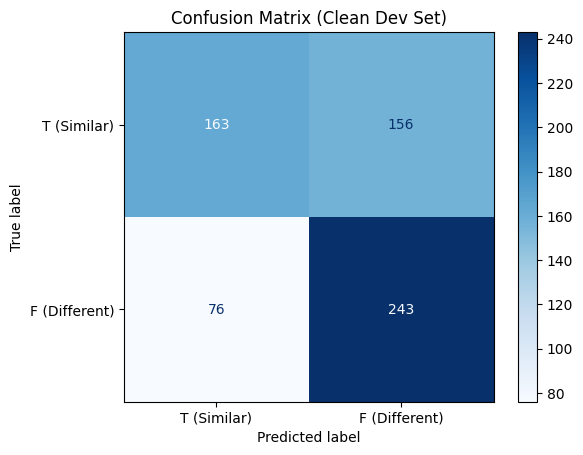

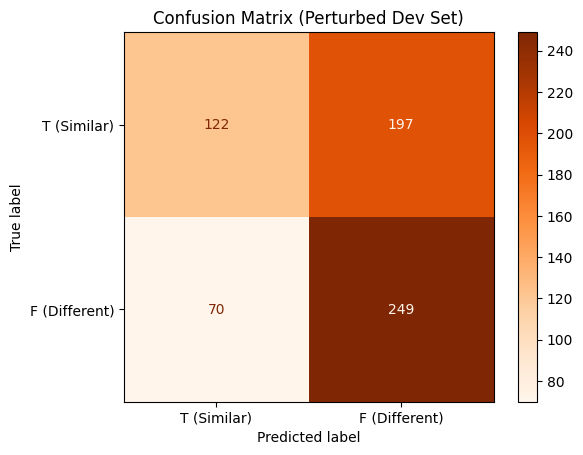

In [ ]:
#step 11: Different metrics evaluation
 from sklearn.metrics import recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


clean_recall = recall_score(dev_gold_labels, predictions, pos_label='T')
clean_f1 = f1_score(dev_gold_labels, predictions, pos_label='T')


perturbed_recall = recall_score(dev_gold_labels, perturbed_dev_data['predictions'], pos_label='T')
perturbed_f1 = f1_score(dev_gold_labels, perturbed_dev_data['predictions'], pos_label='T')

# Print Metrics
print("Clean Dev Set Metrics:")
print(f"Recall: {clean_recall:.2%}")
print(f"F1-Score: {clean_f1:.2%}\n")

print("Perturbed Dev Set Metrics:")
print(f"Recall: {perturbed_recall:.2%}")
print(f"F1-Score: {perturbed_f1:.2%}\n")

# Confusion Matrix for Clean Dev Set
cm_clean = confusion_matrix(dev_gold_labels, predictions, labels=['T', 'F'])  # Use actual labels
disp_clean = ConfusionMatrixDisplay(confusion_matrix=cm_clean, display_labels=['T (Similar)', 'F (Different)'])
disp_clean.plot(cmap='Blues')
plt.title('Confusion Matrix (Clean Dev Set)')
plt.show()

# Confusion Matrix for Perturbed Dev Set
cm_perturbed = confusion_matrix(dev_gold_labels, perturbed_dev_data['predictions'], labels=['T', 'F'])  # Use actual labels
disp_perturbed = ConfusionMatrixDisplay(confusion_matrix=cm_perturbed, display_labels=['T (Similar)', 'F (Different)'])
disp_perturbed.plot(cmap='Oranges')
plt.title('Confusion Matrix (Perturbed Dev Set)')
plt.show()

